# Introduction
This notebook contains a working example to demonstrate the API for visual saliency map generation for image black-box classifiers.

This example will follow an application-like use case where we define a functionally rigid process that transforms an input image into a number of saliency heatmaps based on our black-box classifier's output, visualizing the heatmaps over the input image.
We will show that it is easy to change which of our API implementations are used in the application without impacting the application's successful execution, first using a sliding-window, occlusion-based algorithm and then using RISE algorithms.

This will require us to define a black-box classification model for which to introspect the saliency.
We will fill this role here with a PyTorch Imagenet-pretrained ResNet18 network.
This will be wrapped up in an implementation of the `ClassifyImage` interface for input to our "application."
This sub-classing standardizes classifier operation with our API to support the varying ways classification is performed across toolkits and applications.

### Table of Contents
* [Set Up Environment](#setup-occulsion)
* [The Test Image](#test-image-occulsion)
* [The "Application"](#The-application-occulsion)
* [Black-box Classifier](#Black-box-Classifier-occulsion)
* [`xaitk_saliency` Swappable Implementations](#xaitk_saliency-Swappable-Implementations)
* [Calling the Application](#Calling-the-Application-occlusion)
    * [Sliding Window Method](#Sliding-Window-Method)
    * [RISE](#RISE)
    * [RISE with Debiasing](#RISE-with-Debiasing)

### Miscellaneous
License for test image used may be found in 'COCO-LICENSE.txt'.

#### References
1. Zeiler, Matthew D., and Rob Fergus. "Visualizing and understanding convolutional networks." European conference on computer vision. Springer, Cham, 2014.

2. Petsiuk, Vitali, Abir Das, and Kate Saenko. "Rise: Randomized input sampling for explanation of black-box models." arXiv preprint arXiv:1806.07421 (2018).

<br>

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/OcclusionSaliency.ipynb)

# Set Up Environment <a name="setup-occulsion"></a>

In [1]:
!pip install -qU pip
!pip install -q xaitk-saliency
!pip install -q "torch==1.9.0"
!pip install -q "torchvision==0.10.0"

# The Test Image <a name="test-image-occulsion"></a>
We will test this application on the following image.
We know that this image contains the ImageNet classes of "boxer" and "tiger cat".

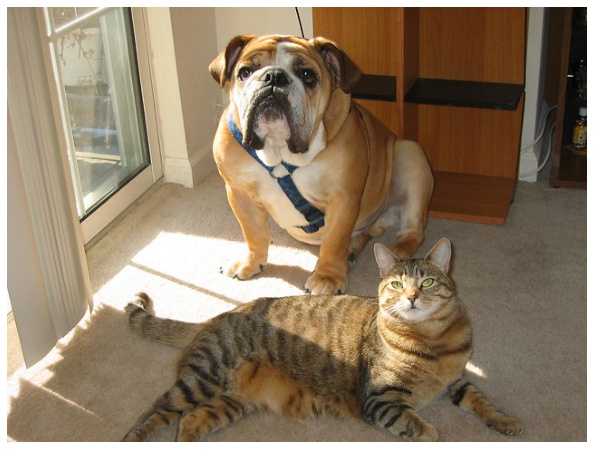

In [2]:
import PIL.Image
import matplotlib.pyplot as plt
import urllib.request


# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


urllib.request.urlretrieve('https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg', "catdog.jpg")
test_image_filename = 'catdog.jpg'
plt.figure(figsize=(12, 8))
plt.axis('off')
_ = plt.imshow(PIL.Image.open(test_image_filename))

# The "Application" <a name=The-application-occulsion></a>
The `xaitk-saliency` package provides a relatively high-level API interface for visual saliency map generation.
This interface defines the following input requirements:
  * a reference image
  * a black-box classifier that performs inference over images

As mentioned above, our high-level API accepts black-box classifiers in terms of the `ClassifyImage` interface.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from smqtk_classifier import ClassifyImage
from xaitk_saliency import GenerateImageClassifierBlackboxSaliency


def app(
    image_filepath: str,
    # Assuming outputs `nClass` length arrays.
    blackbox_classify: ClassifyImage,
    gen_bb_sal: GenerateImageClassifierBlackboxSaliency,
):
    # Load the image
    ref_image = np.asarray(PIL.Image.open(image_filepath))
    sal_maps = gen_bb_sal(ref_image, blackbox_classify)
    print(f"Saliency maps: {sal_maps.shape}")
    visualize_saliency(ref_image, sal_maps)

    
def visualize_saliency(ref_image: np.ndarray, sal_maps: np.ndarray) -> None:    
    # Visualize the saliency heat-maps
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(12, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046*(ref_image.shape[0]/ref_image.shape[1]),
        "pad": 0.04,
    }

    for i, class_sal_map in enumerate(sal_maps):
        print(f"Class {i} saliency map range: [{class_sal_map.min()}, {class_sal_map.max()}]")

        # Positive half saliency
        plt.subplot(2, sub_plot_ind, 2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, 0, 1),
            cmap='jet', alpha=0.3
        )
        plt.clim(0, 1)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Pos Saliency")
        plt.axis('off')

        # Negative half saliency
        plt.subplot(2, sub_plot_ind, sub_plot_ind+2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, -1, 0),
            cmap='jet_r', alpha=0.3
        )
        plt.clim(-1, 0)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Neg Saliency")
        plt.axis('off')

# Black-box Classifier <a name=Black-box-Classifier-occulsion></a>
In this example, we will use a basic PyTorch-based, pretrained ResNet18 model and use its softmax output as classification confidences.
Since this model normally outputs 1000 classes, we will, for simplicity of example, constrain the output to the two classes that are relevant for our test image.

In [4]:
# Set up our "black box" classifier using PyTorch and it's ImageNet pretrained ResNet18.
# We will constrain the output of our classifier here to the two classes that are relevant
# to our test image for the purposes of this example.
import os
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms

CUDA_AVAILABLE = torch.cuda.is_available()


model = models.resnet18(pretrained=True)
model = model.eval()
if CUDA_AVAILABLE:
    model = model.cuda()

# These are some simple helper functions to perform prediction with this model
model_input_size = (224, 224)
model_mean = [0.485, 0.456, 0.406]
model_loader = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(model_input_size), 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=model_mean,
        std=[0.229, 0.224, 0.225]
    ),
])


# Grabbing the class labels associated with this model.
if not os.path.isfile('imagenet_classes.txt'):
    !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

f = open("imagenet_classes.txt", "r")
categories = [s.strip() for s in f.readlines()]


# For this test, we will use an image with both a cat and a dog in it.
# Let's only consider the saliency of two class predictions.
sal_class_labels = ['boxer', 'tiger cat']
sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]


class TorchResnet18 (ClassifyImage):
    """ Blackbox model to output the two focus classes. """
    
    def get_labels(self):
        return sal_class_labels
    
    @torch.no_grad()
    def classify_images(self, image_iter):
        # Input may either be an NDaray, or some arbitrary iterable of NDarray images.
        
        for img in image_iter:
            image_tensor = model_loader(img).unsqueeze(0)
            if CUDA_AVAILABLE:
                image_tensor = image_tensor.cuda()
            feature_vec = model(image_tensor)
            # Converting feature extractor output to probabilities.
            class_conf = torch.nn.functional.softmax(feature_vec, dim=1).cpu().detach().numpy().squeeze()
            # Only return the confidences for the focus classes
            yield dict(zip(sal_class_labels, class_conf[sal_class_idxs]))
    
    def get_config(self):
        # Required by a parent class.
        return {}
    

blackbox_classifier = TorchResnet18()

blackbox_fill = np.uint8(np.asarray(model_mean) * 255)

# `xaitk_saliency` Swappable Implementations
Here we will manually import and construct a number of `GenerateImageClassifierBlackboxSaliency` implementations.
Since these all implement the same parent [abstract] class, they effectively all promise to abide by the API it defines.
Thus, we should be able to use them all interchangebly, at least at the functional level.
Their implementations may of course produce different results, as is the point of having varying implementations, but the types and form of the inputs and outputs should be the same.

The implementations here use perturbation-occlusion sub-pipelines as shown in this diagram.
![](figures/perturb_occlude_diagram.svg)

As mentioned before, we will first construct sliding-window, occlusion-based implementations and then RISE implementations.

In [5]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.rise import RISEStack
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

gen_slidingwindow = SlidingWindowStack((50, 50), (20, 20), threads=4)
gen_rise = RISEStack(1000, 8, 0.5, seed=0, threads=4, debiased=False)
gen_rise_debiased = RISEStack(1000, 8, 0.5, seed=0, threads=4, debiased=True)

# Calling the Application <a name=Calling-the-Application-occlusion></a>
In the below cells, we will show that we can invoke the same "application" (function) with different `xaitk-saliency` API interface implementations while still successfully executing and visualizing the different results that are generated.

## Sliding Window Method

/home/brian/.cache/pypoetry/virtualenvs/xaitk-saliency-BlgCxOoJ-py3.7/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-1.0, 0.6352883840990408]
Class 1 saliency map range: [-1.0, 0.9723985898191845]


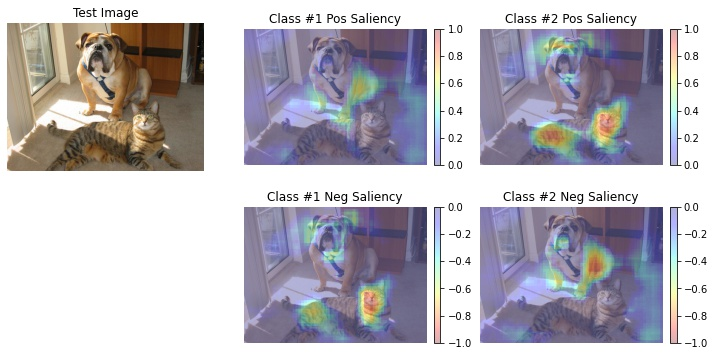

In [6]:
# This generator implementation has a slot for filling background occlusion,
# which our choice of classifier should ideally take for best operation.
gen_slidingwindow.fill = blackbox_fill

app(
    test_image_filename,
    blackbox_classifier,
    gen_slidingwindow,
)

## RISE

Saliency maps: (2, 480, 640)
Class 0 saliency map range: [0.4051729738712311, 1.0]
Class 1 saliency map range: [0.6819127202033997, 1.0]


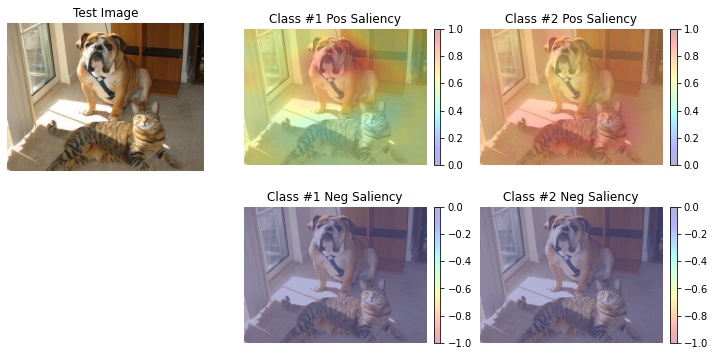

In [7]:
# This generator implementation has a slot for filling background occlusion,
# which our choice of classifier should ideally take for best operation.
gen_rise.fill = blackbox_fill

app(
    test_image_filename,
    blackbox_classifier,
    gen_rise
)

## RISE with Debiasing

Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-0.5133521556854248, 1.0]
Class 1 saliency map range: [-0.5018323063850403, 1.0]


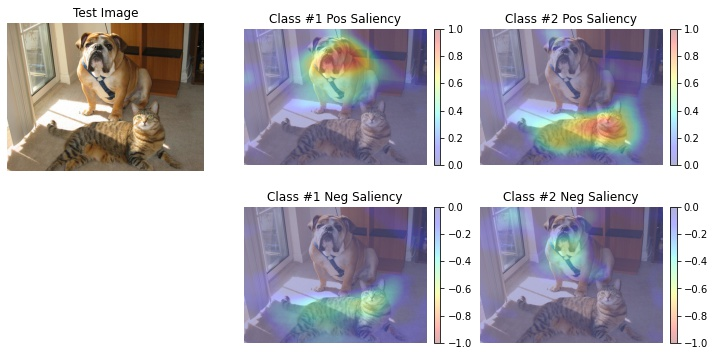

In [8]:
# This generator implementation has a slot for filling background occlusion,
# which our choice of classifier should ideally take for best operation.
gen_rise_debiased.fill = blackbox_fill

app(
    test_image_filename,
    blackbox_classifier,
    gen_rise_debiased,
)